In [212]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from shapely.validation import make_valid
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.lines import Line2D

In [213]:
PATH_FINAL_CLASS = r"/Users/hester/Desktop/data/final_suitability_class.tif"
countries_shp    = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
uk_parts_path    = r"/Users/hester/Desktop/data/Countries/CTRY_DEC_2022_UK_BFC_v2_c.shp"

In [214]:
with rasterio.open(PATH_FINAL_CLASS) as src:
    cls = src.read(1).astype("float32")
    r_crs = src.crs
    bounds = src.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top

A = cls.copy()
A[(A != 3) & (A != 4)] = np.nan  

cmap = ListedColormap([
    "#2ca25f", 
    "#de2d26", 
])
norm = BoundaryNorm([2.5, 3.5, 4.5], cmap.N)

In [215]:

uk0 = gpd.read_file(countries_shp)
# Natural Earth字段有时是 ADMIN，有时是 NAME
if "ADMIN" in uk0.columns:
    uk0 = uk0[uk0["ADMIN"] == "United Kingdom"]
else:
    uk0 = uk0[uk0["NAME"] == "United Kingdom"]
uk0 = uk0.to_crs(r_crs)

uk_parts = gpd.read_file(uk_parts_path).to_crs(r_crs)

uk_parts.columns = uk_parts.columns.str.strip()

In [216]:
color_map = {
    "England": "#E6D8B8",          
    "Scotland": "#FFFFFF",         
    "Wales": "#D6E5D8",            
    "Northern Ireland": "#E8D6D6", 
}
uk_parts["fill"] = uk_parts[name_col].map(color_map).fillna("#EEEEEE")

uk_parts["label_point"] = uk_parts.geometry.representative_point()

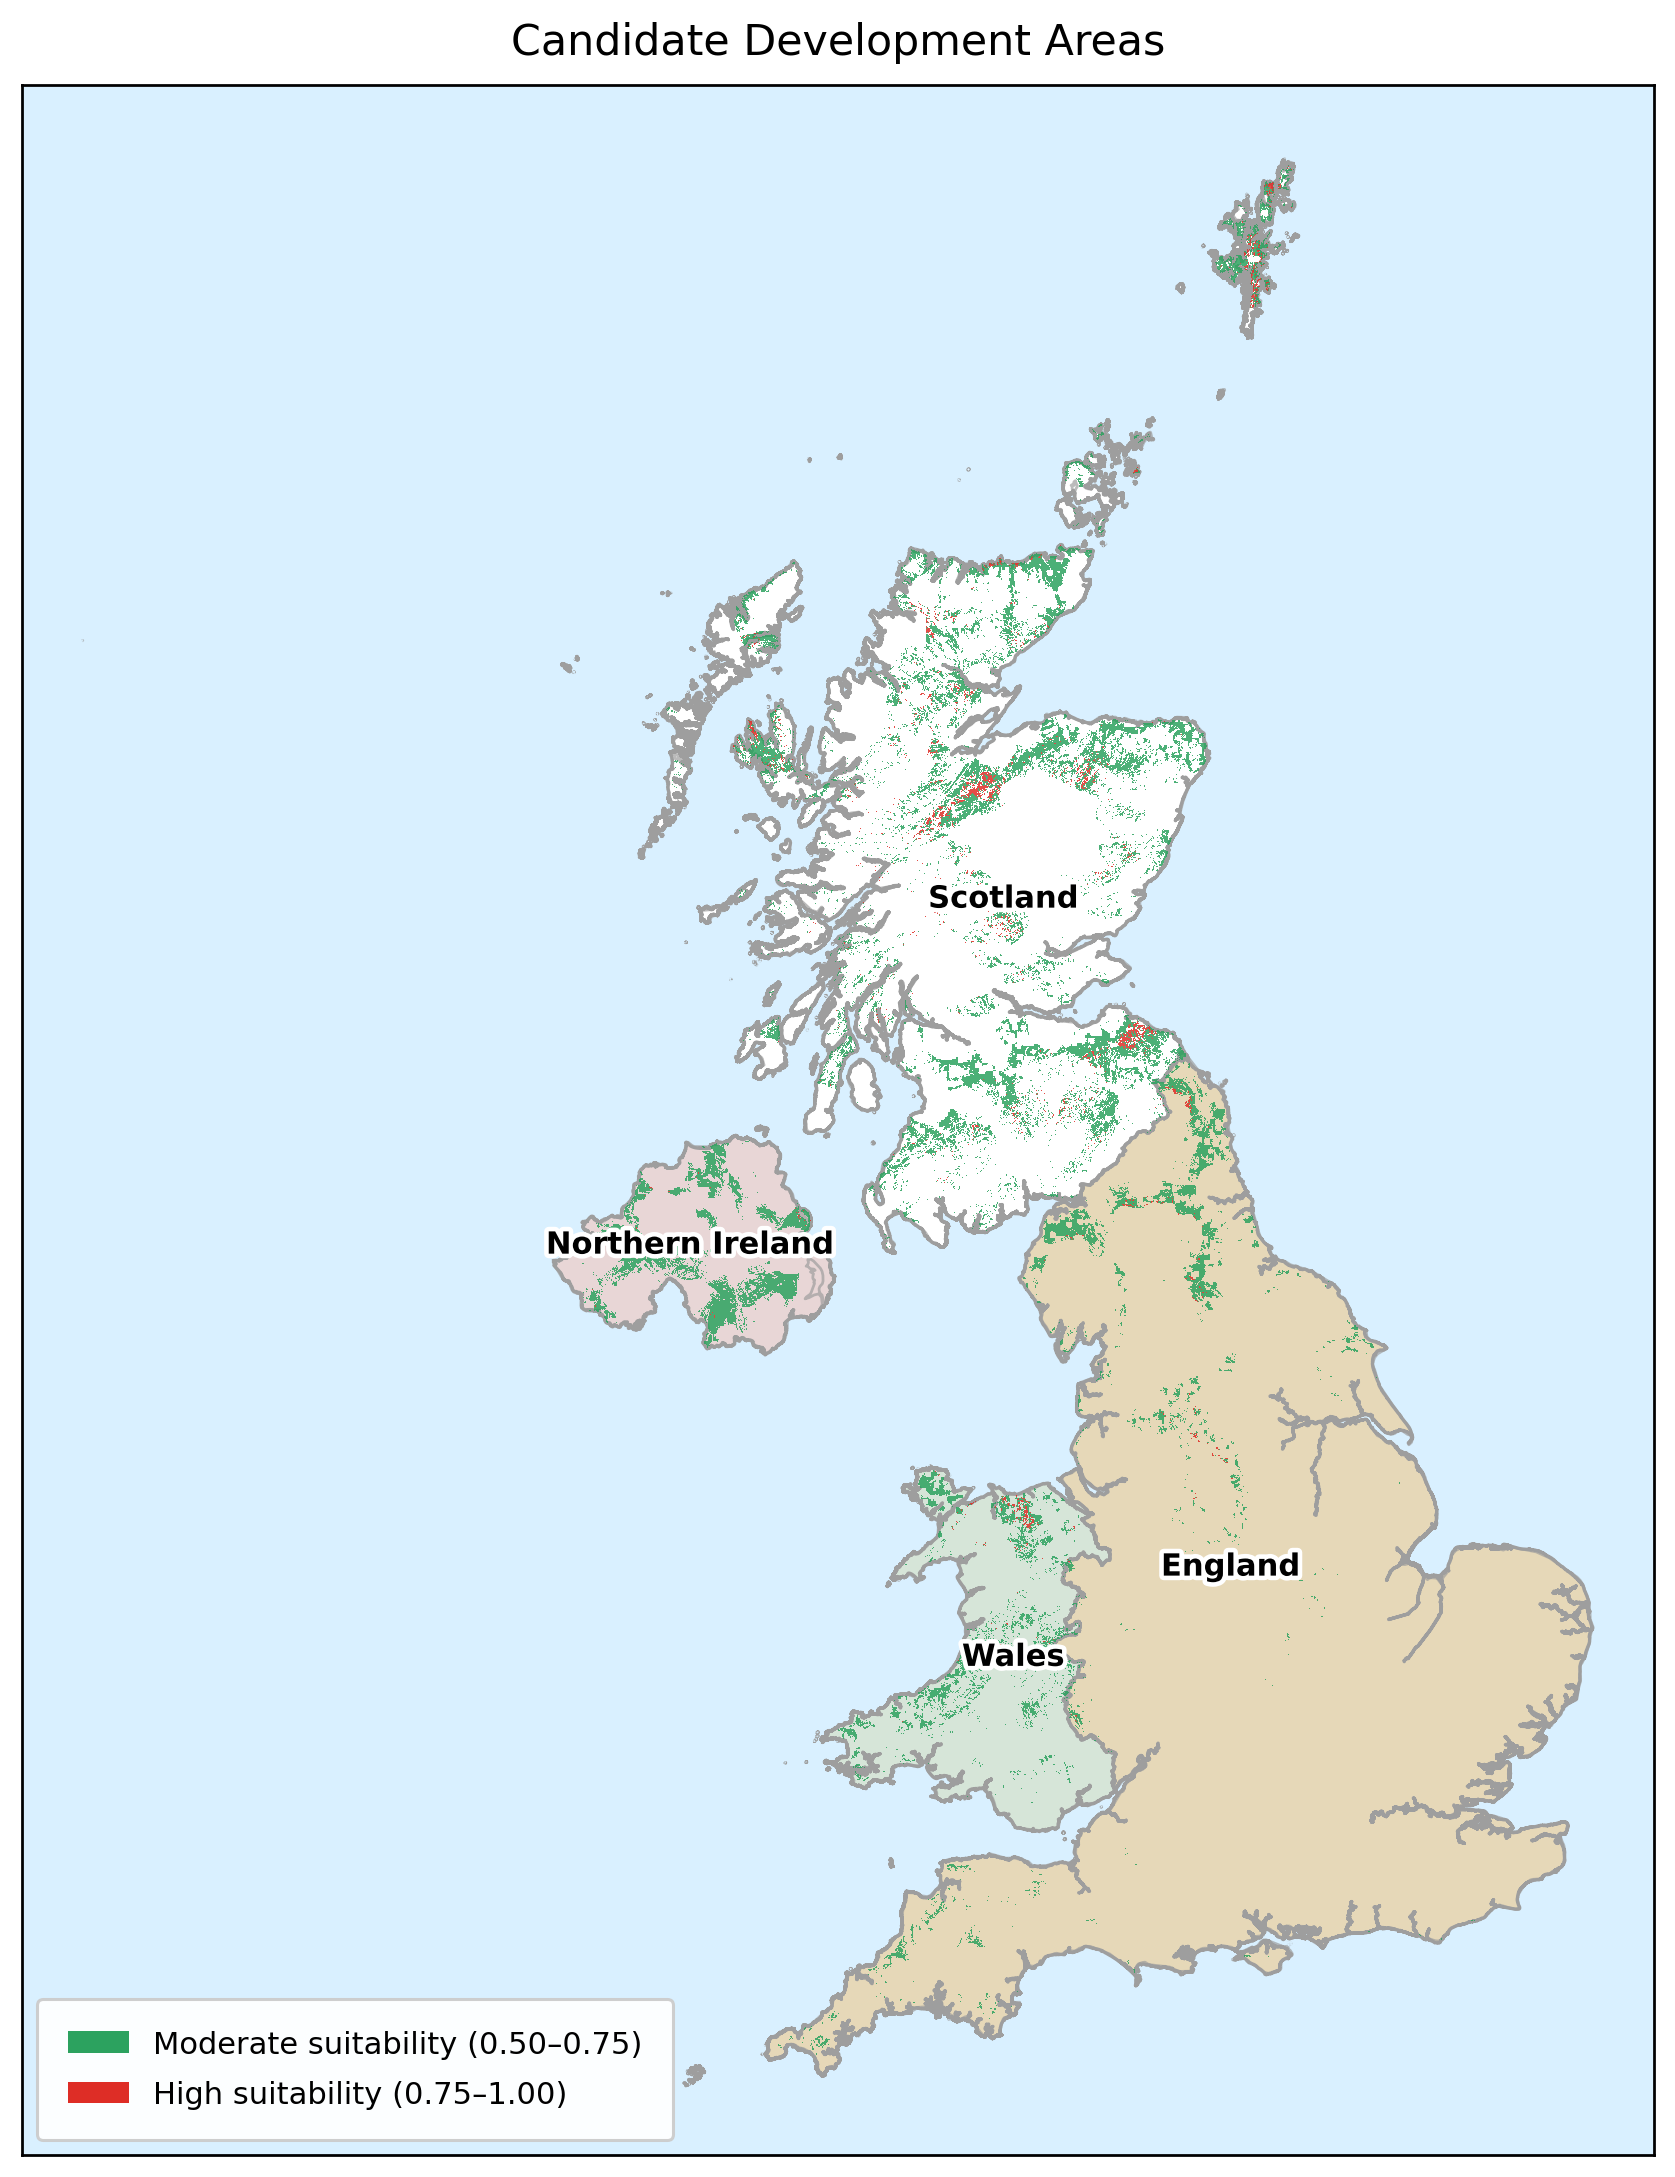

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10), dpi=220)

ax.set_facecolor("#d9f0ff")

uk_parts.plot(ax=ax, color=uk_parts["fill"], edgecolor="none", zorder=1)

uk_parts.boundary.plot(ax=ax, color="#9e9e9e", linewidth=1.1, zorder=2)

ax.imshow(
    A,
    cmap=cmap,
    norm=norm,
    extent=(left, right, bottom, top),
    origin="upper",
    interpolation="nearest",
    alpha=0.85,
    zorder=3
)

uk0.boundary.plot(ax=ax, edgecolor="#9e9e9e",alpha=0.7, linewidth=0.9, zorder=2)

for _, row in uk_parts.iterrows():
    p = row["label_point"]
    ax.text(
        p.x, p.y,
        row[name_col],
        fontsize=10,   
        fontweight="bold",
        ha="center", va="center",
        color="black",
        zorder=10,
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

legend_elements = [
    Patch(facecolor="#2ca25f", edgecolor="none", label="Moderate suitability (0.50–0.75)"),
    Patch(facecolor="#de2d26", edgecolor="none", label="High suitability (0.75–1.00)")
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=10,
          frameon=True, framealpha=0.95, borderpad=1.0, labelspacing=0.7)

ax.set_title("Candidate Development Areas", fontsize=14, pad=10)

minx, miny, maxx, maxy = uk0.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()

fig.savefig("Candidate Development Areas.png", dpi=300, bbox_inches="tight")

In [218]:
PATH_FINAL_CLASS = r"/Users/hester/Desktop/data/final_suitability_class.tif"
PATH_FINAL_SCORE = r"/Users/hester/Desktop/data/final_suitability_score.tif"

In [219]:
QUOTAS = {
    "Scotland": 9,
    "England": 6,
    "Wales": 3,
    "Northern Ireland": 2
}
EXCLUSION_RADIUS_KM = 40    
TOP_CANDIDATES_TO_SCAN = 600       

In [186]:
def attach_country(points_gdf, uk_parts_gdf, name_col="CTRY22NM"):
    pts = points_gdf.copy()
    parts = uk_parts_gdf[[name_col, "geometry"]].copy()
    parts = parts.rename(columns={name_col: "country"})
    joined = gpd.sjoin(pts, parts, how="left", predicate="within")
    joined = joined.drop(columns=[c for c in joined.columns if c.startswith("index_")], errors="ignore")
    return joined

In [220]:
with rasterio.open(PATH_FINAL_CLASS) as src:
    cls = src.read(1).astype("float32")
    r_crs = src.crs
    transform = src.transform
    bounds = src.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top

    pixel_w = abs(transform.a)
    pixel_h = abs(transform.e)
    pixel_area_m2 = pixel_w * pixel_h

score = None
try:
    with rasterio.open(PATH_FINAL_SCORE) as ssrc:
        sc = ssrc.read(1).astype("float32")
        snodata = ssrc.nodata
        if snodata is not None:
            sc[sc == snodata] = np.nan
        score = sc
except Exception:
    score = None

mask = (cls == 3) | (cls == 4)

# If no score, approximate by class
if score is None:
    score = np.full_like(cls, np.nan, dtype="float32")
    score[cls == 3] = 0.625
    score[cls == 4] = 0.875

In [221]:
structure = np.ones((3, 3), dtype=np.uint8) 
labels_arr, nlab = label(mask.astype(np.uint8), structure=structure)
print("Number of candidate patches:", nlab)

flat_lab = labels_arr.ravel()
flat_score = np.where(mask.ravel(), score.ravel(), 0.0)

counts = np.bincount(flat_lab)             
sum_score = np.bincount(flat_lab, weights=flat_score)

lab_ids = np.arange(1, len(counts))               
pix_count = counts[1:]
mean_score = np.divide(sum_score[1:], pix_count, out=np.zeros_like(sum_score[1:]), where=pix_count > 0)

area_km2 = (pix_count * pixel_area_m2) / 1e6
rank_score = mean_score + 0.15 * np.log1p(area_km2)

Number of candidate patches: 10208


In [222]:
top_idx = np.argsort(rank_score)[::-1][:TOP_CANDIDATES_TO_SCAN]
top_lab_ids = lab_ids[top_idx]

candidates = []
for lab in top_lab_ids:
    ys, xs = np.where(labels == lab)
    if len(xs) == 0:
        continue
    x_coords, y_coords = rasterio.transform.xy(transform, ys, xs, offset="center")
    cx = float(np.mean(x_coords))
    cy = float(np.mean(y_coords))
    candidates.append({
        "patch_id": int(lab),
        "mean_score": float(mean_score[lab-1]),
        "area_km2": float(area_km2[lab-1]),
        "rank": float(rank_score[lab-1]),
        "geometry": Point(cx, cy)
    })

cand_gdf = gpd.GeoDataFrame(candidates, crs=r_crs)

In [223]:
uk0 = gpd.read_file(countries_shp)
if "ADMIN" in uk0.columns:
    uk0 = uk0[uk0["ADMIN"] == "United Kingdom"]
else:
    uk0 = uk0[uk0["NAME"] == "United Kingdom"]
uk0 = uk0.to_crs(r_crs)

uk_parts = gpd.read_file(uk_parts_path).to_crs(r_crs)
uk_parts.columns = uk_parts.columns.str.strip()

name_col = "CTRY22NM"
if name_col not in uk_parts.columns:
    raise ValueError(f"Missing column {name_col}. Available columns: {list(uk_parts.columns)}")

cand_gdf = attach_country(cand_gdf, uk_parts, name_col=name_col)
cand_gdf = cand_gdf[cand_gdf["country"].notna()].copy()

In [224]:
RADIUS_M = EXCLUSION_RADIUS_KM * 1000.0
use_metric = cand_gdf.copy()
metric_crs = r_crs
if hasattr(r_crs, "is_geographic") and r_crs.is_geographic:
    metric_crs = "EPSG:27700"
    use_metric = use_metric.to_crs(metric_crs)

selected_rows = []
selected_geom = []
quota_left = QUOTAS.copy()

use_metric = use_metric.sort_values("rank", ascending=False)

for _, row in use_metric.iterrows():
    c = row["country"]
    if c not in quota_left:
        continue
    if quota_left[c] <= 0:
        continue
    p = row.geometry

    ok = True
    for sp in selected_geom:
        if p.distance(sp) < RADIUS_M:
            ok = False
            break
    if not ok:
        continue

    selected_rows.append(row)
    selected_geom.append(p)
    quota_left[c] -= 1

    if sum(quota_left.values()) == 0:
        break

if sum(quota_left.values()) != 0:
    print("⚠️ 配额没填满，剩余：", quota_left, "（可把半径调小或把 TOP_CANDIDATES_TO_SCAN 调大）")

selected = gpd.GeoDataFrame(selected_rows, crs=metric_crs)

# 转回 raster CRS 用于绘图/输出
selected_sites = selected.to_crs(r_crs).copy()
selected_sites["site_id"] = np.arange(1, len(selected_sites) + 1)

print(selected_sites[["site_id", "country", "mean_score", "area_km2"]].head(30))

    site_id           country  mean_score    area_km2
0         1          Scotland    0.652132  888.863280
1         2          Scotland    0.680861  682.730043
2         3          Scotland    0.600190  632.970460
3         4           England    0.588330  557.116857
4         5  Northern Ireland    0.546396  726.156587
5         6          Scotland    0.617725  432.551242
6         7             Wales    0.679885  274.844316
7         8          Scotland    0.577712  499.310031
8         9          Scotland    0.597527  399.838483
9        10  Northern Ireland    0.567470  470.406618
10       11          Scotland    0.636921  293.129177
13       12           England    0.621334  263.368661
14       13           England    0.573955  347.174274
15       14          Scotland    0.751562   99.900100
17       15           England    0.622096  206.466555
18       16          Scotland    0.574743  274.796699
19       17             Wales    0.609793  174.087114
32       18             Wale

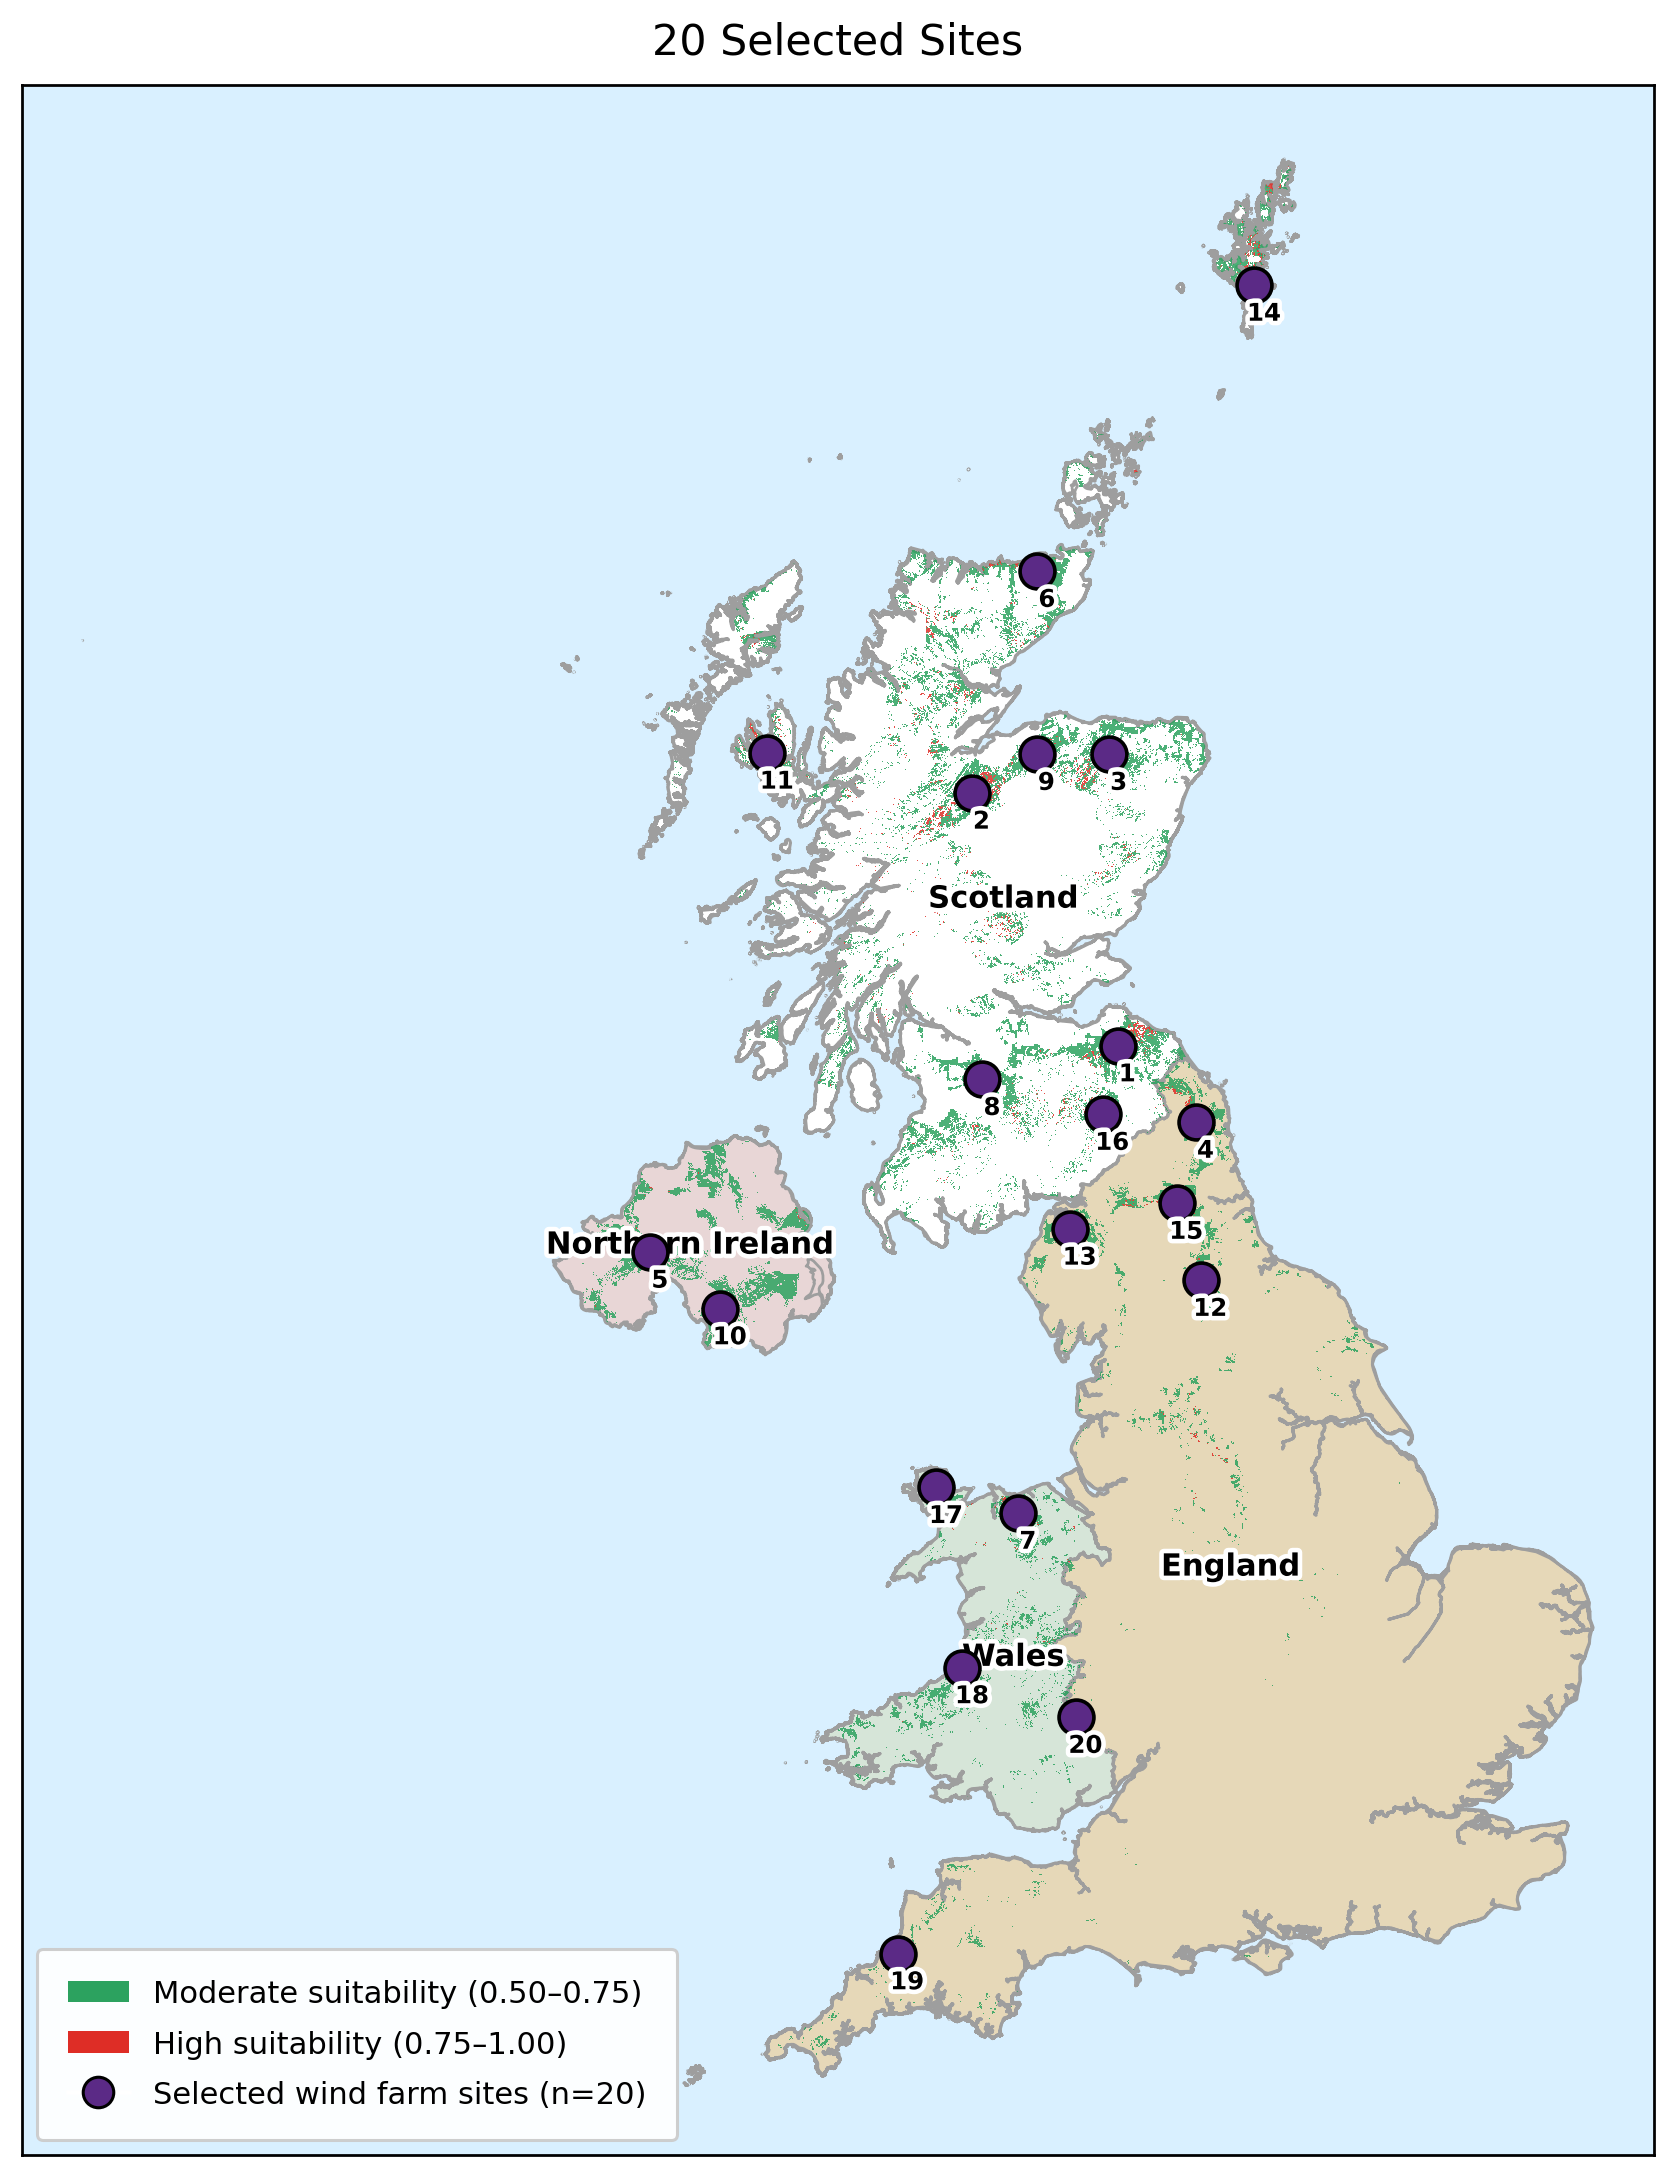

In [225]:
A = cls.copy()
A[(A != 3) & (A != 4)] = np.nan

cmap = ListedColormap(["#2ca25f", "#de2d26"])
norm = BoundaryNorm([2.5, 3.5, 4.5], cmap.N)

color_map = {
    "England": "#E6D8B8",
    "Scotland": "#FFFFFF",
    "Wales": "#D6E5D8",
    "Northern Ireland": "#E8D6D6",
}
uk_parts["fill"] = uk_parts[name_col].map(color_map).fillna("#EEEEEE")
uk_parts["label_point"] = uk_parts.geometry.representative_point()

fig, ax = plt.subplots(1, 1, figsize=(8, 10), dpi=220)
ax.set_facecolor("#d9f0ff")

uk_parts.plot(ax=ax, color=uk_parts["fill"], edgecolor="none", zorder=1)
uk_parts.boundary.plot(ax=ax, color="#9e9e9e", linewidth=1, zorder=2)

ax.imshow(
    A, cmap=cmap, norm=norm,
    extent=(left, right, bottom, top),
    origin="upper", interpolation="nearest",
    alpha=0.85, zorder=3
)

uk0.boundary.plot(ax=ax, edgecolor="#9e9e9e", linewidth=0.9, zorder=4)

for _, row in uk_parts.iterrows():
    p = row["label_point"]
    ax.text(
        p.x, p.y, row[name_col],
        fontsize=10, fontweight="bold",
        ha="center", va="center", color="black",
        zorder=10,
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

selected_sites.plot(
    ax=ax, color="#5B2A86", markersize=130, zorder=20,
    edgecolor="black", linewidth=1.2
)

dx, dy = 6000, -18000
for _, r in selected_sites.iterrows():
    x, y = r.geometry.x, r.geometry.y
    #if int(r["site_id"]) == 18:
        #x += 12000
        #y -= 8000
    ax.text(
        x + dx, y + dy, str(int(r["site_id"])),
        fontsize=8, fontweight="bold",
        ha="center", va="center", color="black",
        zorder=21,
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

legend_elements = [
    Patch(facecolor="#2ca25f", edgecolor="none", label="Moderate suitability (0.50–0.75)"),
    Patch(facecolor="#de2d26", edgecolor="none", label="High suitability (0.75–1.00)"),
    Line2D([0], [0], marker='o', color='w',
           label='Selected wind farm sites (n=20)',
           markerfacecolor="#5B2A86", markeredgecolor='black', markersize=10)
]
ax.legend(
    handles=legend_elements, loc="lower left",
    fontsize=10, frameon=True, framealpha=0.95,
    borderpad=1.0, labelspacing=0.7
)

ax.set_title("20 Selected Sites", fontsize=14, pad=10)

minx, miny, maxx, maxy = uk0.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_aspect("equal", adjustable="box")
ax.set_xticks([]); ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()

fig.savefig("20 Selected Sites.png", dpi=300, bbox_inches="tight")

In [226]:
import numpy as np
import rasterio
from scipy.ndimage import distance_transform_edt

PATH_TRA = r"/Users/hester/Desktop/data/tra_binary.tif"
OUT_DIST_KM = r"/Users/hester/Desktop/data/dist_to_transmission_km.tif"

with rasterio.open(PATH_TRA) as src:
    tra = src.read(1)
    tra_nodata = src.nodata
    transform = src.transform
    crs = src.crs
    profile = src.profile.copy()

if tra_nodata is not None:
    tra = np.where(tra == tra_nodata, 0, tra)

line_mask = (tra >= 1)

dist_pix = distance_transform_edt(~line_mask) 

px = abs(transform.a)
py = abs(transform.e)
m_per_pix = (px + py) / 2.0
dist_km = dist_pix * m_per_pix / 1000.0

profile.update(dtype="float32", nodata=-9999, compress="lzw")
with rasterio.open(OUT_DIST_KM, "w", **profile) as dst:
    out = dist_km.astype("float32")
    out[np.isnan(out)] = -9999
    dst.write(out, 1)

print("Saved distance raster:", OUT_DIST_KM)

sites = selected_sites.copy()
if sites.crs != crs:
    sites = sites.to_crs(crs)

with rasterio.open(OUT_DIST_KM) as dsrc:
    xy = [(g.x, g.y) for g in sites.geometry]
    dvals = [v[0] for v in dsrc.sample(xy)]

sites["d_km"] = np.array(dvals, dtype=float)
sites.loc[sites["d_km"] < 0, "d_km"] = np.nan  # -9999 -> NaN

print("rows:", len(sites), " unique site_id:", sites["site_id"].nunique())
sites[["site_id","country","d_km"]].sort_values("site_id")

Saved distance raster: /Users/hester/Desktop/data/dist_to_transmission_km.tif
rows: 20  unique site_id: 20


,site_id,country,d_km
0,1,Scotland,0.000000
1,2,Scotland,4.506939
2,3,Scotland,0.000000
3,4,England,0.000000
4,5,Northern Ireland,0.000000
5,6,Scotland,0.000000
6,7,Wales,0.901388
7,8,Scotland,0.000000
8,9,Scotland,0.000000
9,10,Northern Ireland,0.000000


In [227]:
MIN_GRID_DISTANCE_KM = 2.0
sites["d_km_effective"] = sites["d_km"].clip(lower=MIN_GRID_DISTANCE_KM)

sites[["site_id","country","d_km","d_km_effective"]].sort_values("site_id")


,site_id,country,d_km,d_km_effective
0,1,Scotland,0.000000,2.000000
1,2,Scotland,4.506939,4.506939
2,3,Scotland,0.000000,2.000000
3,4,England,0.000000,2.000000
4,5,Northern Ireland,0.000000,2.000000
5,6,Scotland,0.000000,2.000000
6,7,Wales,0.901388,2.000000
7,8,Scotland,0.000000,2.000000
8,9,Scotland,0.000000,2.000000
9,10,Northern Ireland,0.000000,2.000000


In [229]:
P_MW = 500.0
CF = 0.36
price = 70.0                 # USD/MWh
capex_per_MW = 2.0e6         # USD/MW
c_grid = 590.0               # USD/(MW·km)
T = 25
r = 0.07
OPEX = 0.0

# PV factor (closed form)
annuity_factor = (1 - (1 + r) ** (-T)) / r

# Annual energy & discounted energy
E_annual = P_MW * 8760.0 * CF                 # MWh/yr
PV_energy = E_annual * annuity_factor         # MWh

df = sites[["site_id","country","d_km","d_km_effective"]].copy()

# CAPEX
df["CAPEX_build_USD"] = capex_per_MW * P_MW
df["CAPEX_grid_USD"]  = c_grid * P_MW * df["d_km_effective"]
df["CAPEX_total_USD"] = df["CAPEX_build_USD"] + df["CAPEX_grid_USD"]

# Revenue
df["E_annual_MWh"] = E_annual
df["Revenue_annual_USD"] = df["E_annual_MWh"] * price

# NPV (OPEX=0)
df["PV_Revenue_USD"] = df["Revenue_annual_USD"] * annuity_factor
df["NPV_USD"] = df["PV_Revenue_USD"] - df["CAPEX_total_USD"]

# LCOE (OPEX=0)
df["LCOE_USD_per_MWh"] = df["CAPEX_total_USD"] / PV_energy

# Simple payback (undiscounted, for interpretation)
df["Payback_years_simple"] = df["CAPEX_total_USD"] / df["Revenue_annual_USD"]

# Friendly units
df["CAPEX_total_BnUSD"] = df["CAPEX_total_USD"] / 1e9
df["Revenue_annual_MnUSD"] = df["Revenue_annual_USD"] / 1e6
df["NPV_BnUSD"] = df["NPV_USD"] / 1e9

out = df[[
    "site_id","country","d_km","d_km_effective",
    "CAPEX_total_BnUSD","Revenue_annual_MnUSD","NPV_BnUSD",
    "LCOE_USD_per_MWh","Payback_years_simple"
]].sort_values("site_id")

out

,site_id,country,d_km,d_km_effective,CAPEX_total_BnUSD,Revenue_annual_MnUSD,NPV_BnUSD,LCOE_USD_per_MWh,Payback_years_simple
0,1,Scotland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
1,2,Scotland,4.506939,4.506939,1.00133,110.376,0.284946,54.493028,9.071986
2,3,Scotland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
3,4,England,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
4,5,Northern Ireland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
5,6,Scotland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
6,7,Wales,0.901388,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
7,8,Scotland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
8,9,Scotland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
9,10,Northern Ireland,0.000000,2.000000,1.00059,110.376,0.285686,54.452781,9.065286
